# Evaluating the Experiment Dataset

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch

if torch.cuda.is_available():
  dev = "cuda"
else:
  dev = "cpu"
device = torch.device(dev)

print(device)

cuda


### Load in Train/Test/Val Datasets & Preprocess for Tokenization

In [3]:
import pandas as pd 

train_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/aligned_train_df.pickle")  
test_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_test_df.pickle") 
val_df = pd.read_pickle("/home/kkatsy/litMT/experiment_dataset/experiment_val_df.pickle") 

print('train size: ', train_df.shape)
print('val size: ', val_df.shape)
print('test size: ', test_df.shape)

sentences = {}
sentences['train'] = [{'label': row['labels'], 'text':row['concat']} for i, row in train_df.iterrows()]
sentences['test'] = [{'label': row['labels'], 'text':row['concat']} for i, row in test_df.iterrows()]
sentences['val'] = [{'label': row['labels'], 'text':row['concat']} for i, row in val_df.iterrows()]

print('train size: ', len(sentences['train']))
print('val size: ', len(sentences['val']))
print('test size: ', len(sentences['test']))

train size:  (17735, 8)
val size:  (1175, 8)
test size:  (1175, 8)
train size:  17735
val size:  1175
test size:  1175


In [46]:
df = pd.concat([train_df, test_df, val_df], axis=0)
df.head()

,idx,book,labels,concat,translator,sim,src,tgt
0,91,Demons,4,Из лицея молодой человек в первые два года при...,PV,0.976574,Из лицея молодой человек в первые два года при...,For the first two years the young man came hom...
1,1263,Demons,4,"– Вещь короткая; даже, если хотите, по-настоящ...",PV,0.976535,"– Вещь короткая; даже, если хотите, по-настоящ...","""It's a short matter; in fact, if you like, it..."
2,1228,Demons,4,– Да кто? Кто велел вам сюда приходить? – допр...,PV,0.976279,– Да кто? Кто велел вам сюда приходить? – допр...,"""But, who? Who told you to come here?"" Varvara..."
3,289,Demons,4,Так называемое у нас имение Степана Трофимович...,PV,0.976099,Так называемое у нас имение Степана Трофимович...,"Stepan Trofimovich's estate, as we used to cal..."
4,528,Demons,4,"– Шатов? Это брат Дарьи Павловны… <SEP> ""Shato...",PV,0.975940,– Шатов? Это брат Дарьи Павловны…,"""Shatov? He is Darya Pavlovna's brother..."""


In [ ]:
# Mean paragraph length per Translator
for b in train_df.book:
    book = df.loc[df['book'] == b]
    print(b, book['src'].apply(len).mean())

### Overall Distribution of Paragraph Length

In [ ]:
import matplotlib.pyplot as plt 
  
train_len = [len(t['text']) for t in sentences['train']]
max_len = max(train_len)
plt.hist(train_len, bins=70, range=[0,5000], color='powderblue', edgecolor = "black") 
# plt.title('Distribution of Dataset Paragraph Length')
# plt.xlabel('Number of Tokens')
# plt.ylabel('Count')
plt.show() 

### Load In Multilingual BERT

In [5]:
BERT_MODEL = "bert-base-multilingual-cased"

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

In [6]:
import datasets
import pandas as pd

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['train']))
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['val']))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=sentences['test']))

## Tokenization of Paragraphs for mBERT

In our experiments we test three modes of tokenized data. We give our model: 
- 512 tokens of only the translated paragraph
- 256 tokens of the translated paragraphs appended to 256 of the source paragraph; this is done to test if including the original source data improves performance
- 256 tokens of only the translated paragraphs; this we need to compare performance between the other two input formats

### TGT 512

Include the first 512 tokens of translated paragraphs for training/testing.

In [7]:
def preprocess_function_512(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(tgt, padding='max_length', max_length=512, truncation='longest_first')

tokenized_train_512 = train_dataset.map(preprocess_function_512)
tokenized_val_512 = val_dataset.map(preprocess_function_512)
tokenized_test_512 = test_dataset.map(preprocess_function_512)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [ ]:
tokenized_train_512['input_ids'][1]

In [8]:
tokenizer.decode(tokenized_train_512['input_ids'][1])

2024-03-05 16:25:13.513655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'[CLS] " It\'s a short matter ; in fact, if you like, it\'s not even an anecdote, " the beads began spilling out. " However, a novelist might cook up a novel from it in an idle moment. It\'s quite an interesting little matter, Praskovya Ivanovna, and I\'m sure Lizaveta Nikolaevna will listen with curiosity, because there are many things here which, if not queer, are at least quaint. About five years ago, in Petersburg, Nikolai Vsevolodovich got to know this gentleman - this same Mr. Lebyadkin who is standing here with his mouth hanging open and, it seems, was just about to slip away. Forgive me, Varvara Petrovna. Incidentally, I\'d advise you not to take to your heels, mister retired official of the former supply department ( you see, I remember you perfectly ). Both I and Nikolai Vsevolodovich are all too well informed of your local tricks, of which, don\'t forget, you will have to give an accounting. Once again I ask your forgiveness, Varvara Petrovna. Nikolai Vsevolodovich used to c

In [9]:
len(tokenizer.decode(tokenized_train_512['input_ids'][1]))

1999

In [ ]:
decoded_512 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_512]
decoded_512_len = [len(t) for t in decoded_512]

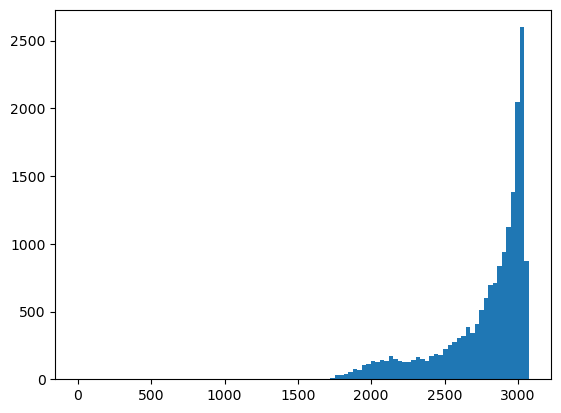

In [57]:
plt.hist(decoded_512_len, bins=100 , range=[0,max(decoded_512_len)]) 
plt.title('Decoded 512 Len - Padded')
plt.show() 

In [61]:
decoded_512_unpadded = [tokenizer.decode(datum['input_ids']).split('[SEP]')[0] for datum in tokenized_train_512]
decoded_512_unpadded_len = [len(t) for t in decoded_512_unpadded]

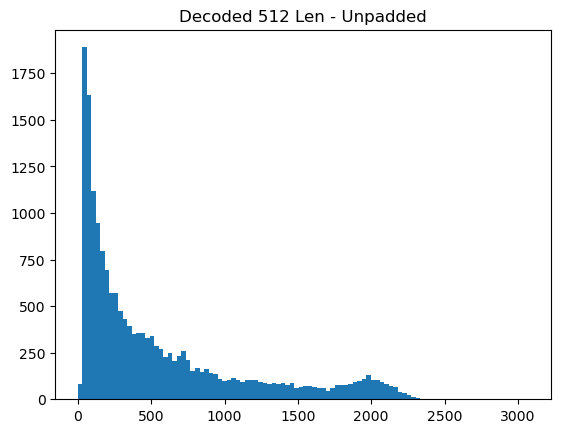

In [63]:
plt.hist(decoded_512_unpadded_len, bins=100 , range=[0,max(decoded_512_len)]) 
plt.title('Decoded 512 Len - Unpadded')
plt.show() 

## TGT 256

Include the first 256 tokens of translated paragraphs for training/testing.

In [50]:
def preprocess_function_256(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(tgt, padding='max_length', max_length=256, truncation='longest_first')

tokenized_train_256 = train_dataset.map(preprocess_function_256)
tokenized_val_256 = val_dataset.map(preprocess_function_256)
tokenized_test_256 = test_dataset.map(preprocess_function_256)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [64]:
decoded_256 = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_256]
decoded_256_len = [len(t) for t in decoded_256]

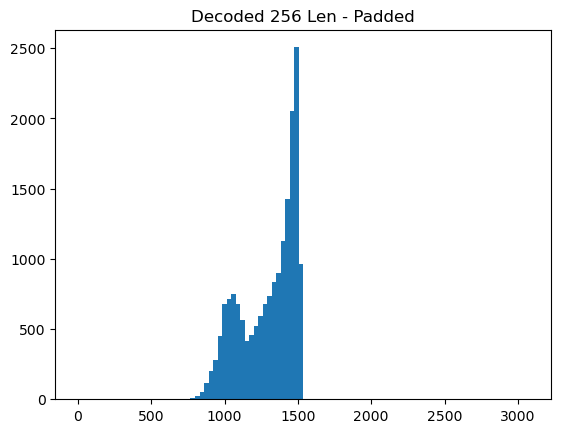

In [65]:
plt.hist(decoded_256_len, bins=100 , range=[0,max(decoded_512_len)]) 
plt.title('Decoded 256 Len - Padded')
plt.show() 

In [77]:
decoded_256_unpadded = [tokenizer.decode(datum['input_ids']).split('[SEP]')[0] for datum in tokenized_train_256]
decoded_256_unpadded_len = [len(t) for t in decoded_256_unpadded]

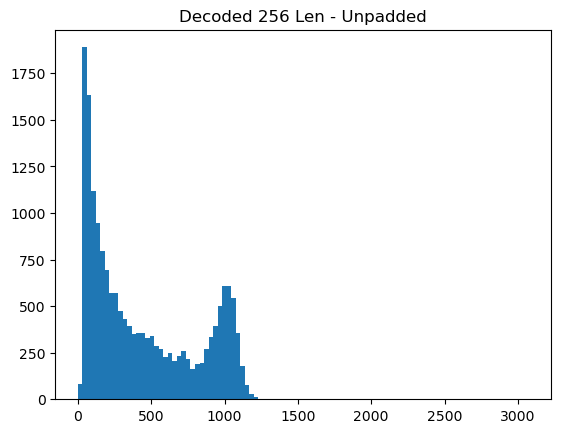

In [78]:
plt.hist(decoded_256_unpadded_len, bins=100 , range=[0,max(decoded_512_len)]) 
plt.title('Decoded 256 Len - Unpadded')
plt.show() 

### SRC + TGT

Include the first 256 tokens of translated paragraph and 256 tokens of the source paragraph for training/testing.

In [80]:
def preprocess_function_concat(datum):
    src, tgt = datum['text'].split(' <SEP> ')
    return tokenizer(src, tgt, padding='max_length', max_length=512, truncation='longest_first')

tokenized_train_concat = train_dataset.map(preprocess_function_concat)
tokenized_val_concat = val_dataset.map(preprocess_function_concat)
tokenized_test_concat = test_dataset.map(preprocess_function_concat)

Map:   0%|          | 0/17735 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

Map:   0%|          | 0/1175 [00:00<?, ? examples/s]

In [81]:
decoded_concat = [tokenizer.decode(datum['input_ids']) for datum in tokenized_train_concat]
decoded_concat_len = [len(t) for t in decoded_concat]

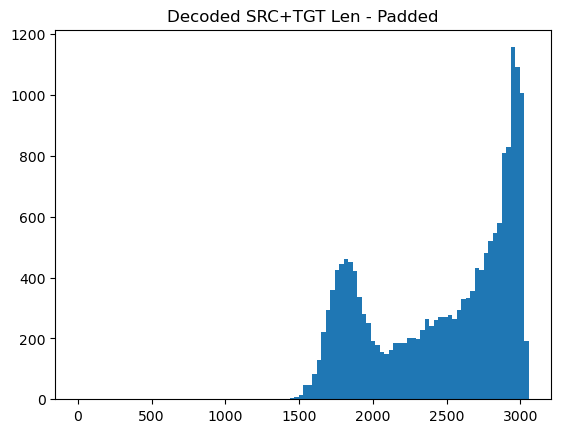

In [82]:
plt.hist(decoded_concat_len, bins=100 , range=[0, max(decoded_concat_len)]) 
plt.title('Decoded SRC+TGT Len - Padded')
plt.show() 

In [85]:
"[SEP]".join(tokenizer.decode(tokenized_train_concat[0]['input_ids']).split("[SEP]", 2)[:2])

"[CLS] Из лицея молодой человек в первые два года приезжал на вакацию. Во время поездки в Петербург Варвары Петровны и Степана Трофимовича он присутствовал иногда на литературных вечерах, бывавших у мамаши, слушал и наблюдал. Говорил мало и всё по - прежнему был тих и застенчив. К Степану Трофимовичу относился с прежним нежным вниманием, но уже как - то сдержаннее : о высоких предметах и о воспоминаниях прошлого видимо удалялся с ним заговаривать. Кончив курс, он, по желанию мамаши, поступил в военную службу и вскоре был зачислен в один из самых видных гвардейских кавалерийских полков. Показаться мамаше в мундире он не приехал и редко стал писать из Петербурга. Денег Варвара Петровна посылала ему не жалея, несмотря на то что после реформы доход с ее имений упал до того, что в первое время она и половины прежнего дохода не полу [[SEP]] For the first two years the young man came home from the lycée for vacations. While Varvara Petrovna and Stepan Trofimovich were in Petersburg, he was so

In [86]:
decoded_concat_unpadded = ["[SEP]".join(tokenizer.decode(datum['input_ids']).split("[SEP]", 2)[:2]) for datum in tokenized_train_concat]
decoded_concat_unpadded_len = [len(t) for t in decoded_concat_unpadded]

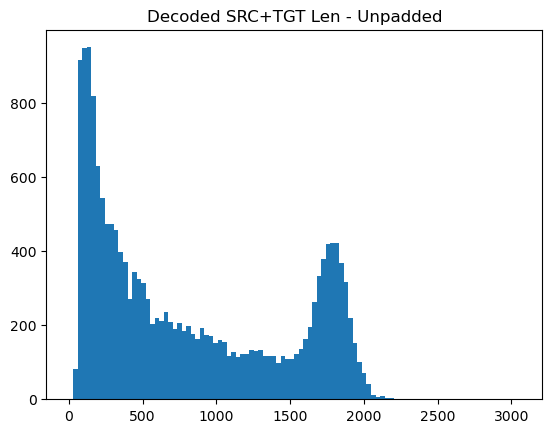

In [87]:
plt.hist(decoded_concat_unpadded_len, bins=100 , range=[0,max(decoded_concat_len)]) 
plt.title('Decoded SRC+TGT Len - Unpadded')
plt.show() 

## Dataset Stats

In [1]:
import pickle

with open('aligned_paragraph_dataset.pickle', 'rb') as fp:
  aligned_paragraph_dataset = pickle.load(fp)

with open('source_paragraph_dataset.pickle', 'rb') as fp:
  source_paragraph_dataset = pickle.load(fp)

#### Number of Paragraphs per Book in Dataset

In [8]:
# Num Paras
total_average = 0
for book in source_paragraph_dataset.keys():
    count = 0
    for p in source_paragraph_dataset[book]:
        if len(p) != 0:
            count += 1
    print(book, ' num paras: ', count)
    total_average += count
    
print('Total: ', total_average / len(source_paragraph_dataset.keys()))

DeadSouls  num paras:  2174
FathersAndSons  num paras:  2068
PoorFolk  num paras:  373
Demons  num paras:  5240
AnnaKarenina  num paras:  7826
NotesFromUnderground  num paras:  544
TheBrothersKaramazov  num paras:  5403
TheIdiot  num paras:  4524
CrimeAndPunishment  num paras:  3828
Total:  3553.3333333333335


#### Average Source Paragraph Length

In [10]:
# Ave Source Len
total_len = 0
for book in source_paragraph_dataset.keys():
    count = 0
    sum = 0
    for p in source_paragraph_dataset[book]:
        if len(p) != 0:
            count += 1
            sum += len(p)
    print(book, ' num paras: ', sum/count)
    total_len += sum/count
    
print('Total: ', total_len / len(source_paragraph_dataset.keys()))

DeadSouls  num paras:  343.6283348666053
FathersAndSons  num paras:  170.29835589941973
PoorFolk  num paras:  673.8445040214477
Demons  num paras:  239.1043893129771
AnnaKarenina  num paras:  216.50983899821108
NotesFromUnderground  num paras:  390.7297794117647
TheBrothersKaramazov  num paras:  333.6524153248196
TheIdiot  num paras:  287.67020335985853
CrimeAndPunishment  num paras:  278.77063740856846
Total:  326.0231620670747


#### Average Target Paragraph Length

In [14]:
# Ave Target Len
total_len = 0
aligned_paragraph_dataset['Demons'][0]
for book in aligned_paragraph_dataset.keys():
    total_para_len = 0
    for para in aligned_paragraph_dataset[book]:
        para_sum = 0
        count = 0

        for t in para.keys():
            if len(para[t]) > 0:
                count += 1
                para_sum += len(para[t])
        if count > 0:
            total_para_len += para_sum/count
    print(book, ' tgt par len: ', total_para_len / len(aligned_paragraph_dataset[book]))
    total_len += total_para_len / len(aligned_paragraph_dataset[book])
    
print('Total: ', total_len / len(aligned_paragraph_dataset.keys()))
            

DeadSouls  tgt par len:  385.5420689655172
FathersAndSons  tgt par len:  207.57926534557757
PoorFolk  tgt par len:  785.3003565062394
Demons  tgt par len:  272.3897157031101
AnnaKarenina  tgt par len:  244.13894212341893
NotesFromUnderground  tgt par len:  463.89831804281346
TheBrothersKaramazov  tgt par len:  385.58871514927216
TheIdiot  tgt par len:  324.28081031307545
CrimeAndPunishment  tgt par len:  321.00515800470095
Total:  376.6359277948584
